# barotropic tides: osmosis

Link to [FES data](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)


In [1]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import tides_pyTMD as td

<Axes: xlabel='lon', ylabel='lat'>

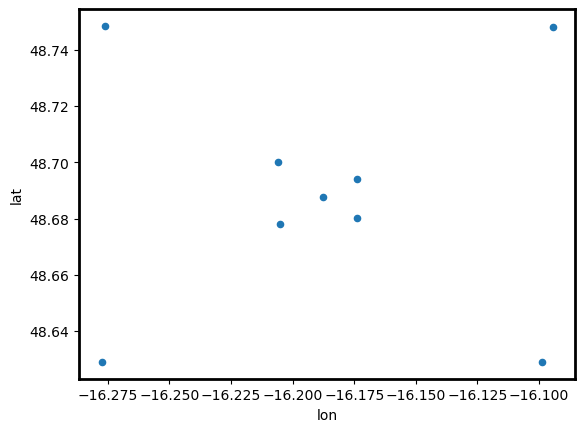

In [2]:
# osm parameters
osm = {"central": dict(lon=-16.1875, lat=48.6875),
           "NE-inner": dict(lon=-16.1740, lat=48.6940),
           "NW-inner": dict(lon=-16.2060, lat=48.7000),
           "SE-inner": dict(lon=-16.1740, lat=48.6803),
           "SW-inner": dict(lon=-16.2050, lat=48.6780),
           "NE-outer": dict(lon=-16.0945, lat=48.7480),
           "NW-outer": dict(lon=-16.2762, lat=48.7485),
           "SE-outer": dict(lon=-16.0990, lat=48.6290),
           "SW-outer": dict(lon=-16.2775, lat=48.6290),
}
osm = pd.DataFrame(osm).T
osx = osm.to_xarray().rename(index="mooring")
osm.plot.scatter("lon", "lat")

---

## constituents, frequencies, equilibrium tides

In [3]:
td.cproperties

,amplitude,phase,omega,alpha,species,omega_cpd
m3,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
eps2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
n4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mtm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
sa,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msqm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
lambda2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msf,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mks2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
s4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000


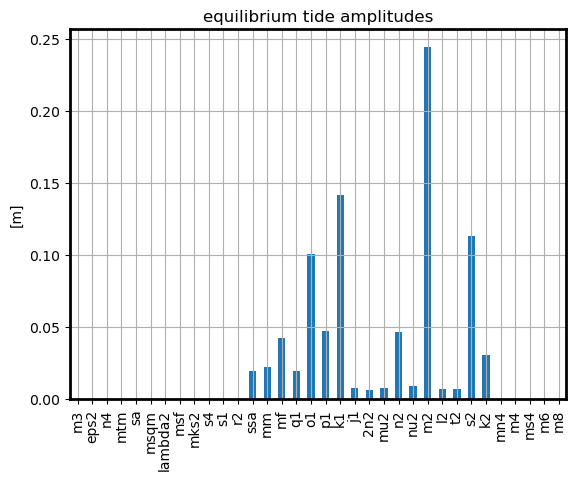

In [4]:
ax = td.cproperties.amplitude.plot.bar()
ax.set_title("equilibrium tide amplitudes")
ax.set_ylabel("[m]")
ax.grid()

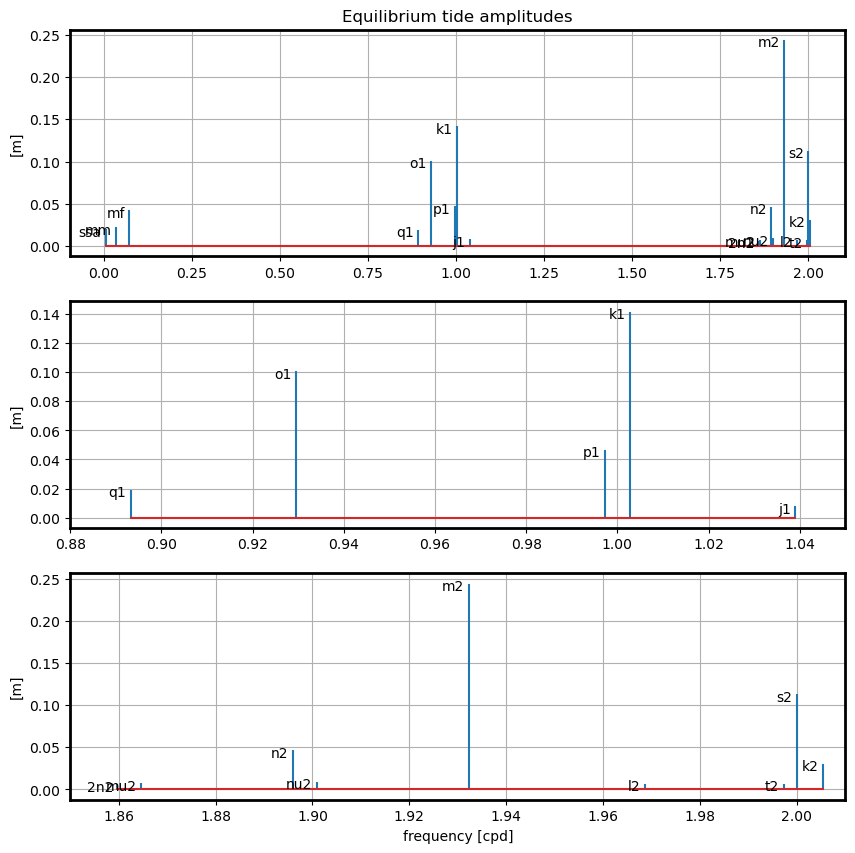

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))
td.plot_equilibrium_amplitudes(td.cproperties, axes[0])
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[1], xlim=(.88, 1.05))
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[2], xlim=(1.85, 2.01))

for i in range(0,2):
    axes[i].set_xlabel("")
for i in range(1,3):
    axes[i].set_title("")

### play with tidal arguments used for predictions

$
\begin{align}
\eta = \mathcal{R} \Big \{  \sum_k h_k \times f_k(t) h_c e^{i (g_k(t) + u_k(t) ) }  \Big \}
\end{align}
$

$g_k (t)$ is the equilibrium argument, it is common to all models
$f_l(t)$ and $u_k(t)$ are nodal corrections.


Constituents have unit complex amplitudes here:

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/load_nodal_corrections.py:109: DeprecationWarning: Deprecated. Please use pyTMD.arguments instead
  warnings.warn("Deprecated. Please use pyTMD.arguments instead",


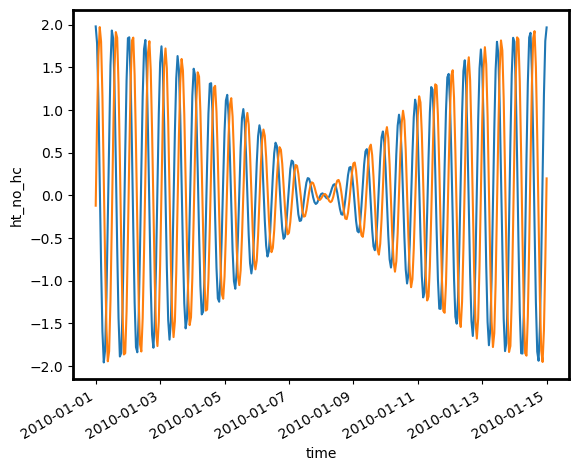

In [6]:
time = pd.date_range(start="2010/01/01", end="2010/01/15", freq="H")

ds = td.get_tidal_arguments(time)

np.real(ds["ht_no_hc"]).sel(constituents=td.major_semidiurnal).sum("constituents").plot()
np.imag(ds["ht_no_hc"]).sel(constituents=td.major_semidiurnal).sum("constituents").plot()

---

## harmonic amplitudes

In [7]:
lon, lat = (-25, 5), (35, 60)

broadcasting lon/lat


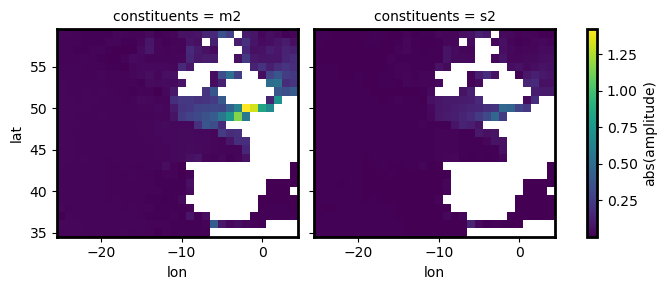

In [8]:

vtype = "u"

ds = td.load_tidal_amplitudes(lon, lat, vtype, constituents=td.major_semidiurnal)

(np.abs(ds[vtype+"_amplitude"])
 .rename("abs(amplitude)")
 .plot(x="lon", y="lat", col="constituents", col_wrap=2)
)

In [9]:
ds = td.load_tidal_amplitudes(osx.lon, osx.lat, ["z", "u", "v"], constituents=td.major_semidiurnal)

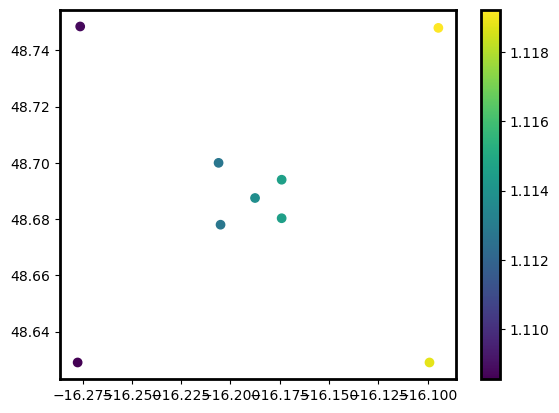

In [10]:
fig, ax = plt.subplots(1,1)
h = ax.scatter(ds.lon, ds.lat, c=np.abs(ds.z_amplitude).sum("constituents"))
fig.colorbar(h)

In [11]:
ds = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat, constituents=td.major_semidiurnal)

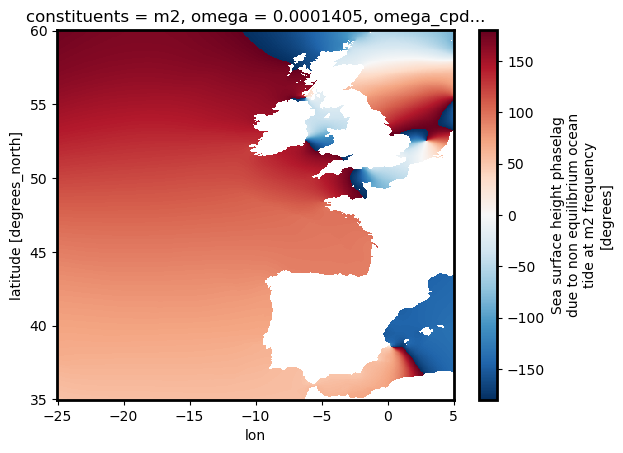

In [12]:
ds.sea_level_phase.sel(constituents="m2").plot()

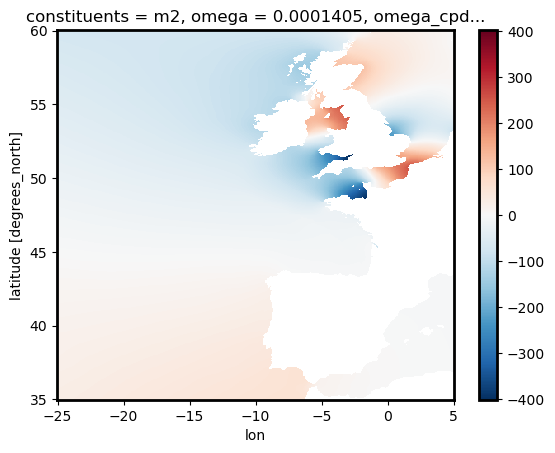

In [13]:
np.real(ds.sea_level_amplitude*np.exp(1j*ds.sea_level_phase*np.pi/180)).sel(constituents="m2").plot()

---

## predictions

In [14]:
#time = pd.date_range("2000/01/01","2000/02/01", freq="1H")

#osx["x"] = ("x", np.arange(10))
#ds = tidal_prediction( (osx.lon+osx.x*0).rename("lon"), (osx.lat+osx.x*0).rename("lat"))

#ds = td.tidal_prediction( osx.lon, osx.lat, time, ["z", "u", "v"]) # all constituents (with inference)
ds = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"], constituents=td.major_semidiurnal, minor=False)

ds

<xarray.Dataset>
Dimensions:  (mooring: 9, time: 337)
Coordinates:
  * mooring  (mooring) object 'central' 'NE-inner' ... 'SE-outer' 'SW-outer'
  * time     (time) datetime64[ns] 2010-01-01 2010-01-01T01:00:00 ... 2010-01-15
Data variables:
    lon      (mooring) float64 -16.19 -16.17 -16.21 ... -16.28 -16.1 -16.28
    lat      (mooring) float64 48.69 48.69 48.7 48.68 ... 48.75 48.63 48.63
    z_tide   (mooring, time) float64 -0.6069 -0.0914 0.4488 ... -0.7797 -0.3477
    u_tide   (mooring, time) float64 0.02695 0.02602 0.01844 ... 0.0235 0.0262
    v_tide   (mooring, time) float64 -0.02639 -0.009996 ... -0.03093 -0.01819

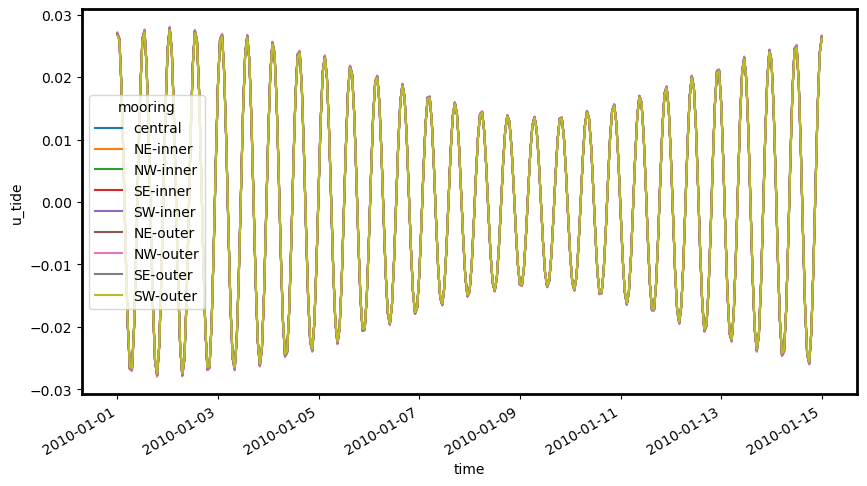

In [15]:
ax = plt.subplots(1,1, figsize=(10,5))
ds["u_tide"].plot(hue="mooring");

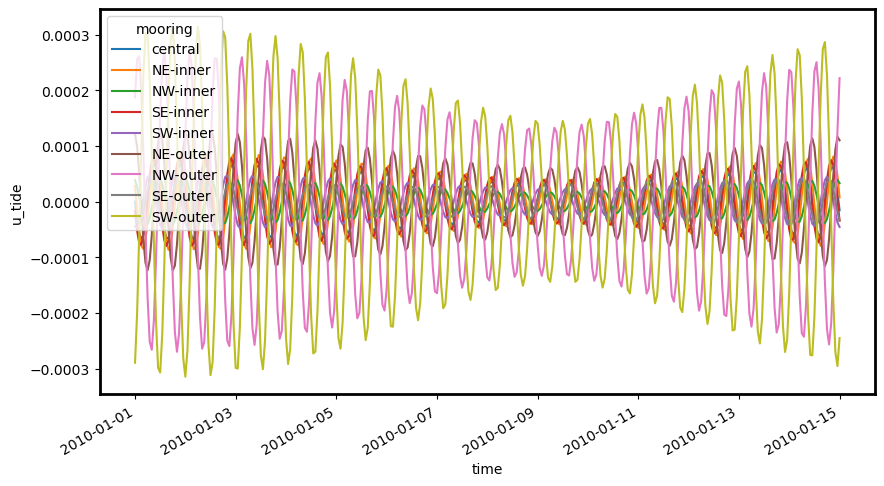

In [16]:
ax = plt.subplots(1,1, figsize=(10,5))
(ds["u_tide"] - ds["u_tide"].mean("mooring")).plot(hue="mooring");

---

## store for XY

### all harmonics in area of interest

In [17]:
lon, lat = (-20, -10), (45, 55)

h = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat)

In [18]:
h.to_zarr("osmosis_harmonics.zarr", mode="w")

### total tidal time series at mooring locations over period of interest

In [19]:
time = pd.date_range(start="2012/09/01", end="2013/09/10", freq="H")

In [20]:
#constituents=td.major_semidiurnal, 
ts = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"])

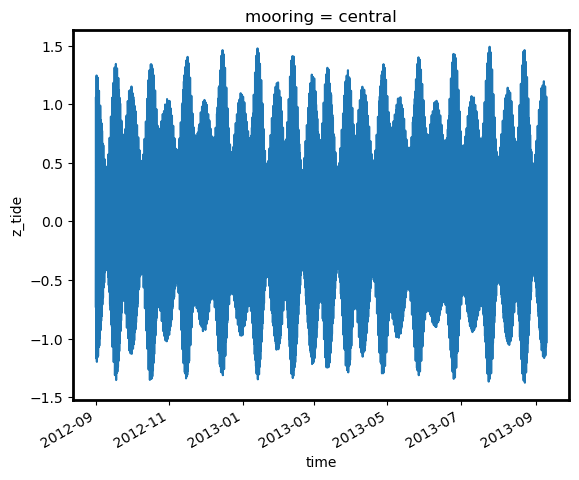

In [24]:
ts["z_tide"].isel(mooring=0).plot()

In [25]:
ts.to_zarr("osmosis_time_series.zarr", mode="w")

### semidiurnal & diurnal contributions

In [31]:
ts = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"], constituents=td.semidiurnal, minor=False)
ts.to_zarr("osmosis_time_series_semidiurnal.zarr", mode="w")

In [32]:
ts = td.tidal_prediction(osx.lon, osx.lat, time, ["z", "u", "v"], constituents=td.diurnal, minor=False)
ts.to_zarr("osmosis_time_series_diurnal.zarr", mode="w")

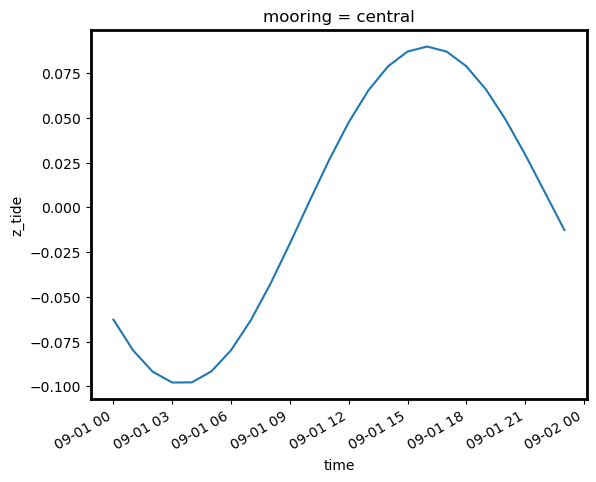

In [33]:
ts["z_tide"].isel(mooring=0, time=slice(0,24)).plot()